# Ancestry PCA and data ancestry inference

In [1]:
library(data.table)
library(tidyverse)
library(class)
library(ggsci)
# library(ggpubr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpose()



In [2]:
setwd("../../all_data/isec_R2_greater_than_3/ancestry/pca/")

### Prep: Load data

In [3]:
pcainput <- fread("data.ref.eigenvec", data.table = F)
onekgpop <- fread("/u/project/gandalm/shared/refGenomes/1000genomes/chrs/kgp.pop", data.table = F)

In [4]:
pcainlist <- pcainput$V2 %in% onekgpop$IID
onekglist <- onekgpop$IID %in% pcainput$V2
# check ref samples have same IID in kgp.pop and merged data
sum(as.vector(pcainput[pcainlist,]$V2) != as.vector(onekgpop[onekglist,]$IID))

[1] 0

In [71]:
sum(pcainlist)

[1] 2504

In [72]:
sum(onekglist)

[1] 2504

### 1: Assign population

In [5]:
pcainput$suppop <- "Data"
pcainput$Pop <- "Data"
onekgpop$suppop <- NA

In [74]:
table(onekgpop$POP)


ACB ASW BEB CDX CEU CHB CHS CLM ESN FIN GBR GIH GWD IBS ITU JPT KHV LWK MSL MXL 
 96  61  86  93  99 103 105  94  99  99  91 103 113 107 102 104  99  99  85  64 
PEL PJL PUR STU TSI YRI 
 85  96 104 102 107 108 

In [75]:
length(unique(onekgpop$POP))

[1] 26

In [6]:
for(i in 1:dim(onekgpop)[1]) {
  if (onekgpop[i,"POP"] %in% c("GBR", "IBS", "CEU", "TSI", "FIN")) {
    onekgpop[i,"suppop"] <- "EUR"
  }
  if (onekgpop[i,"POP"] %in% c("MXL", "PUR", "CLM", "PEL")) {
    onekgpop[i,"suppop"] <- "AMR"
  }
  if (onekgpop[i,"POP"] %in% c("YRI", "LWK", "GWD", "MSL", "ESN", "ASW", "ACB")) {
    onekgpop[i,"suppop"] <- "AFR"
  }
  if (onekgpop[i,"POP"] %in% c("GIH", "PJL", "BEB", "STU", "ITU")) {
    onekgpop[i,"suppop"] <- "SEA"
  }
  if (onekgpop[i,"POP"] %in% c("CHB", "JPT", "CHS", "CDX", "KHV")) {
    onekgpop[i,"suppop"] <- "EA"
  }
}

In [77]:
head(onekgpop)

,FID,IID,POP,suppop
,<int>,<chr>,<chr>,<chr>
1,0,HG00096,GBR,EUR
2,0,HG00097,GBR,EUR
3,0,HG00099,GBR,EUR
4,0,HG00100,GBR,EUR
5,0,HG00101,GBR,EUR
6,0,HG00102,GBR,EUR


In [7]:
pcainput[pcainlist,]$Pop <- as.vector(onekgpop[onekglist,]$POP)
pcainput[pcainlist,]$suppop <- as.vector(onekgpop[onekglist,]$suppop)

In [8]:
poplevels <- c("GBR", "IBS", "CEU", "TSI", "FIN",               # EUR
              "MXL", "PUR", "CLM", "PEL",                      # Admix American
              "YRI", "LWK", "GWD", "MSL", "ESN", "ASW", "ACB", # African
              "GIH", "PJL", "BEB", "STU", "ITU",               # SEA
              "CHB", "JPT", "CHS", "CDX", "KHV",               # EA
              "Data")

In [9]:
poplevels2 <- c("EUR", "AMR", "AFR", "SEA", "EA", "Data")

pcainput$Pop <- factor(pcainput$Pop, levels = poplevels)
pcainput$suppop <- factor(pcainput$suppop, levels = poplevels2)

### 2: Make plots

In [81]:
table(pcainput$suppop)


 EUR  AMR  AFR  SEA   EA Data 
 503  347  661  489  504  654 

In [84]:
pcainput$suppop <- gsub("Data", "Fetal sample", pcainput$suppop)

In [115]:
pcainput$suppop <- factor(pcainput$suppop, levels = c("Fetal sample", "EUR", "AMR", "AFR", "EA", "SEA"))

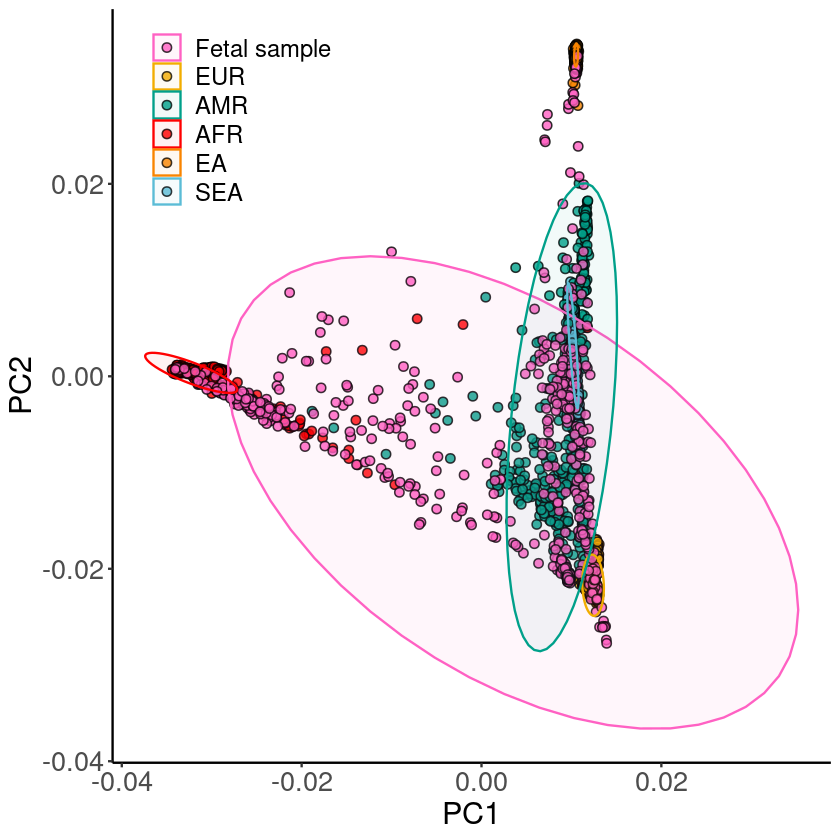

In [130]:
# 1: PC1 vs PC2
# pal <- wes_palette("Darjeeling1")
pal <- c("AFR" = "#FF0000", "AMR" = "#00A08A", "EUR" = "#F2AD00", 
         "EA" = "#F98400", "SEA" = "#5BBCD6", "Fetal sample" = "#FF61C3")

ggplot(pcainput, aes(x = V3, y = V4, color = suppop, fill = suppop)) +
  geom_point(size = 2, shape = 21, color = "black", alpha = 0.8) +
#   geom_point(alpha = 0.8) +
  stat_ellipse(geom = "polygon", alpha = 0.05) +
  labs(x = "PC1", 
       y = "PC2") +
  theme_classic() +
  theme(axis.text = element_text(size = 16),
        axis.title = element_text(size = 18),
        legend.title = element_text(size = 16),
        legend.text = element_text(size = 14),
        legend.position = c(0.18, 0.88)) +
  scale_fill_manual("", values = pal) +
  scale_colour_manual("", values = pal)
#   scale_color_locuszoom() +
#   scale_fill_locuszoom()

In [131]:
ggsave("~/project-gandalm/isoform_twas/genotype/figures/PC1vsPC2.pdf", width = 6, height = 6)

In [10]:
# scree plot: percentage of explained variance
eigenval <- read.table("data.ref.eigenval")
head(eigenval)

,V1
,<dbl>
1,225.60700
2,65.65290
3,18.35360
4,14.38060
5,8.63292
6,5.38558


In [11]:
dim(eigenval)

[1] 20  1

In [11]:
eigenval <- eigenval %>% mutate(percent = 100*V1/sum(eigenval$V1))
eigenval$PC <- seq(1, 20)
# eigenval$PC <- as.character(eigenval$PC)
# eigenval$PC <- factor(eigenval$PC, levels = unique(eigenval$PC))

In [12]:
head(eigenval)

,V1,percent,PC
,<dbl>,<dbl>,<int>
1,225.60700,59.906448,1
2,65.65290,17.433112,2
3,18.35360,4.873514,3
4,14.38060,3.818546,4
5,8.63292,2.292338,5
6,5.38558,1.430057,6


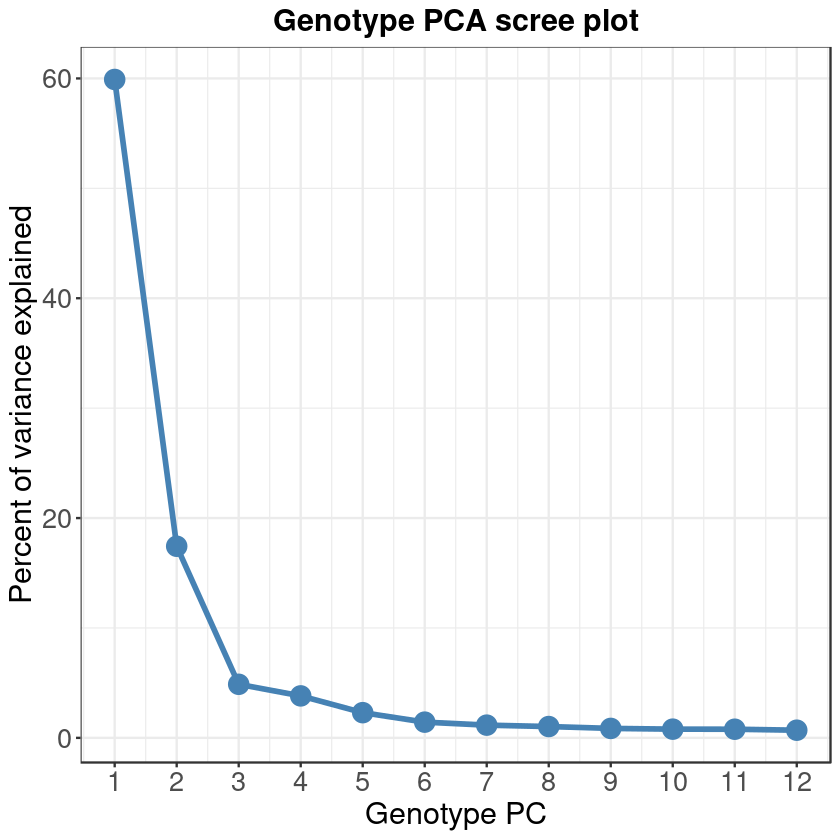

In [20]:
ggplot(eigenval[1:12,], aes(x = PC, y = percent)) +
    geom_point(size = 5, color = "steelblue") +
    geom_line(color = "steelblue", size = 1.2) +
    labs(x = "Genotype PC", 
         y = "Percent of variance explained",
         title = "Genotype PCA scree plot") +
  theme_bw() +
  scale_x_continuous(breaks = seq(0,13,by = 1)) +
  theme(axis.text = element_text(size = 16),
        axis.title = element_text(size = 18),
       plot.title = element_text(size = 18, face = "bold", hjust = 0.5))

In [21]:
ggsave("~/project-gandalm/isoform_twas/genotype/figures/scree.pdf", width = 6, height = 6)

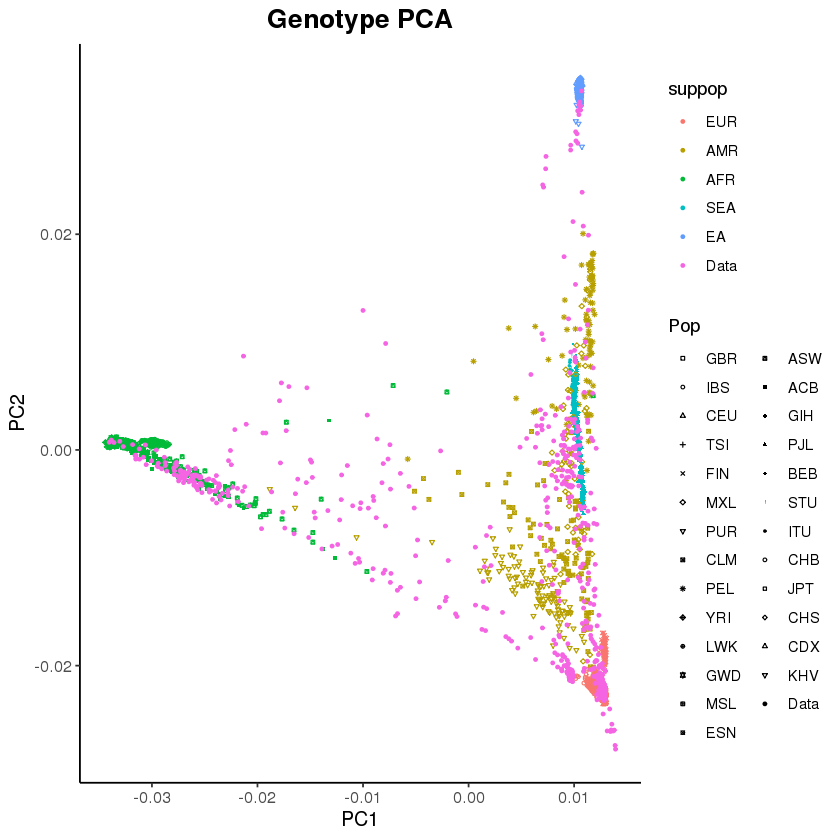

In [28]:
# 2: PC1 vs PC2 by population
p2 <- ggplot(pcainput, aes(x = V3, y = V4, color = suppop, shape = Pop)) +
  geom_point(size=.7) +
  scale_shape_manual(values = c(0:18,33,20:25,19)) +
  labs(x = "PC1", y = "PC2", title = "Genotype PCA") +
  theme_classic() +
  theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5))
p2

ggsave("~/project-gandalm/isoform_twas/genotype/figures/PC1vsPC2_pop.png", p2, width=9, height=6)

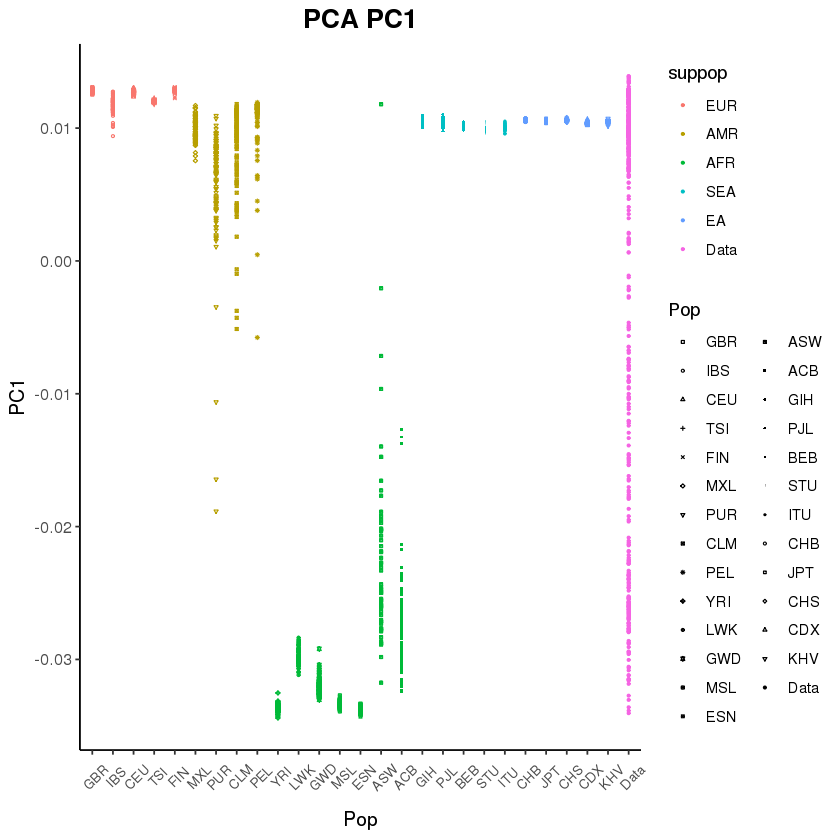

In [29]:
# 3: plot PC1-5 only
p3 <- ggplot(pcainput, aes(x = Pop, y = V3, shape = Pop, color = suppop)) +
  geom_point(size=.5) +
  scale_shape_manual(values = c(0:18,33,20:25,19)) +
  labs(y = "PC1", title = "PCA PC1") +
  theme_classic() +
  theme(axis.text = element_text(size=10),
        axis.text.x = element_text(angle = 45, size=8, margin = margin(0.4, unit = "cm")),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5))
p3
ggsave("~/project-gandalm/isoform_twas/genotype/figures/PC1.png", p3, width = 9, height = 6)

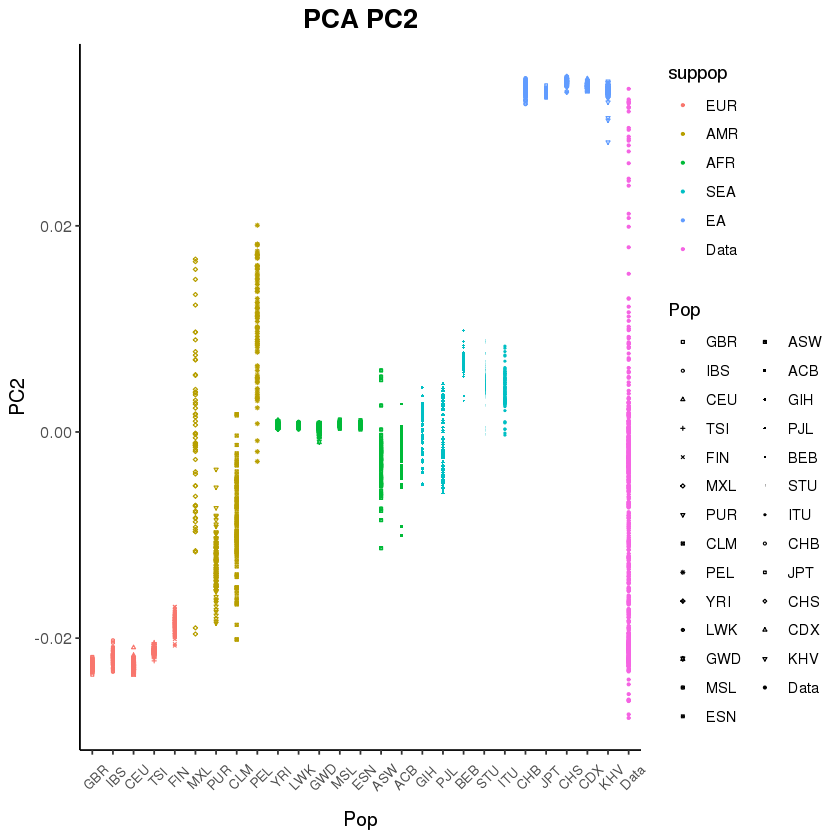

In [30]:
p3 <- ggplot(pcainput, aes(x = Pop, y = V4, shape = Pop, color = suppop)) +
  geom_point(size=.5) +
  scale_shape_manual(values = c(0:18,33,20:25,19)) +
  labs(y = "PC2", title = "PCA PC2") +
  theme_classic() +
  theme(axis.text = element_text(size=10),
        axis.text.x = element_text(angle = 45, size=8, margin = margin(0.4, unit = "cm")),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5))
p3
ggsave("~/project-gandalm/isoform_twas/genotype/figures/PC2.png", p3, width = 9, height = 6)

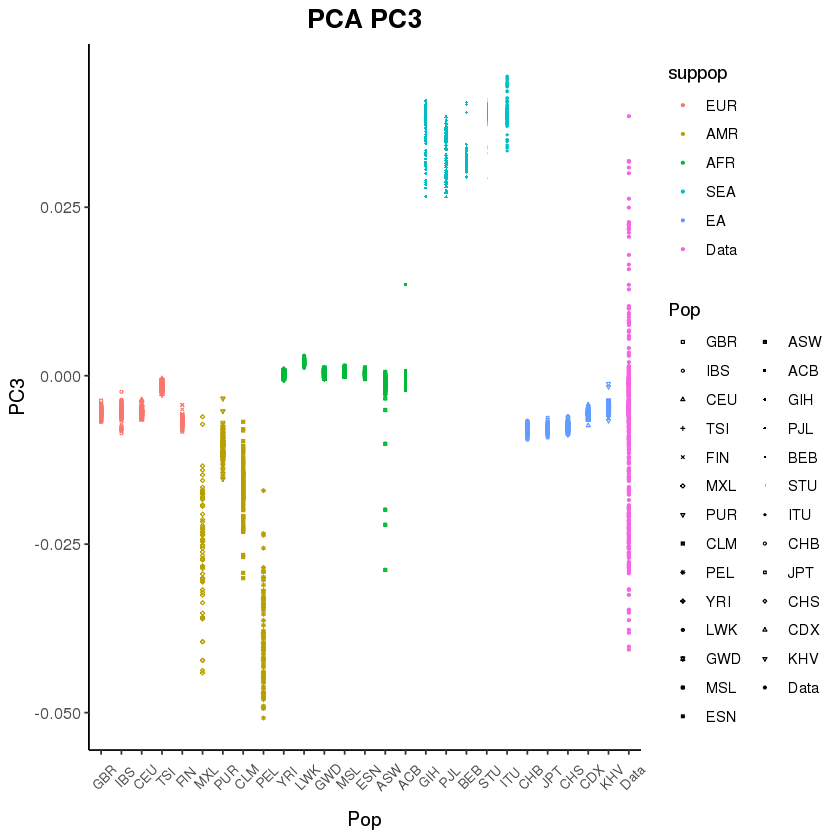

In [31]:
p3 <- ggplot(pcainput, aes(x = Pop, y = V5, shape = Pop, color = suppop)) +
  geom_point(size=.5) +
  scale_shape_manual(values = c(0:18,33,20:25,19)) +
  labs(y = "PC3", title = "PCA PC3") +
  theme_classic() +
  theme(axis.text = element_text(size=10),
        axis.text.x = element_text(angle = 45, size=8, margin = margin(0.4, unit = "cm")),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5))
p3
ggsave("~/project-gandalm/isoform_twas/genotype/figures/PC3.png", p3, width = 9, height = 6)

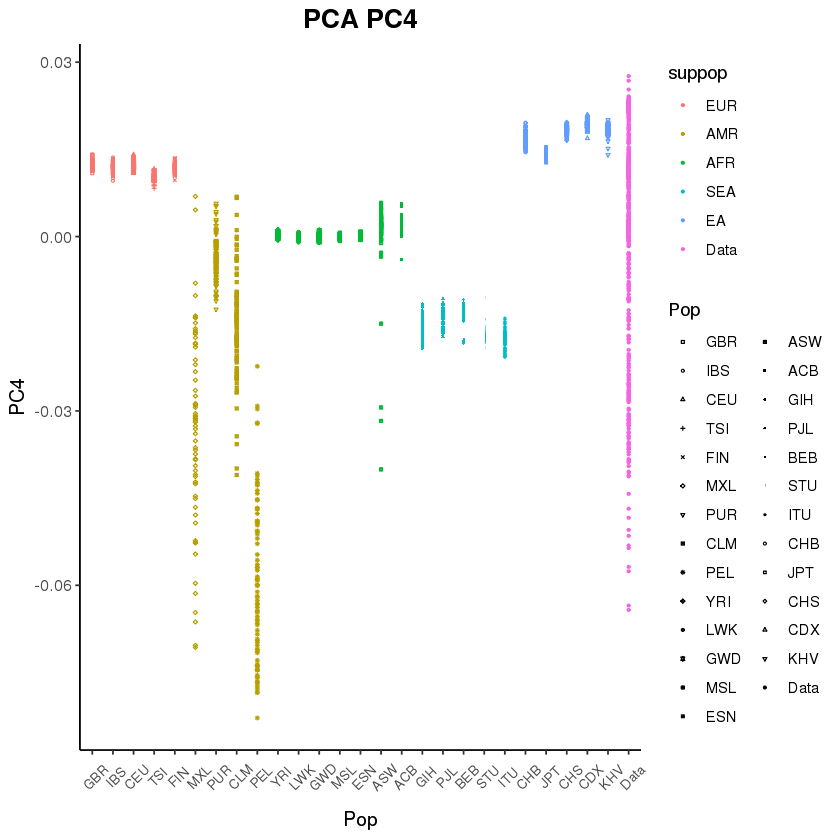

In [32]:
p3 <- ggplot(pcainput, aes(x = Pop, y = V6, shape = Pop, color = suppop)) +
  geom_point(size=.5) +
  scale_shape_manual(values = c(0:18,33,20:25,19)) +
  labs(y = "PC4", title = "PCA PC4") +
  theme_classic() +
  theme(axis.text = element_text(size=10),
        axis.text.x = element_text(angle = 45, size=8, margin = margin(0.4, unit = "cm")),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5))
p3
ggsave("~/project-gandalm/isoform_twas/genotype/figures/PC4.png", p3, width = 9, height = 6)

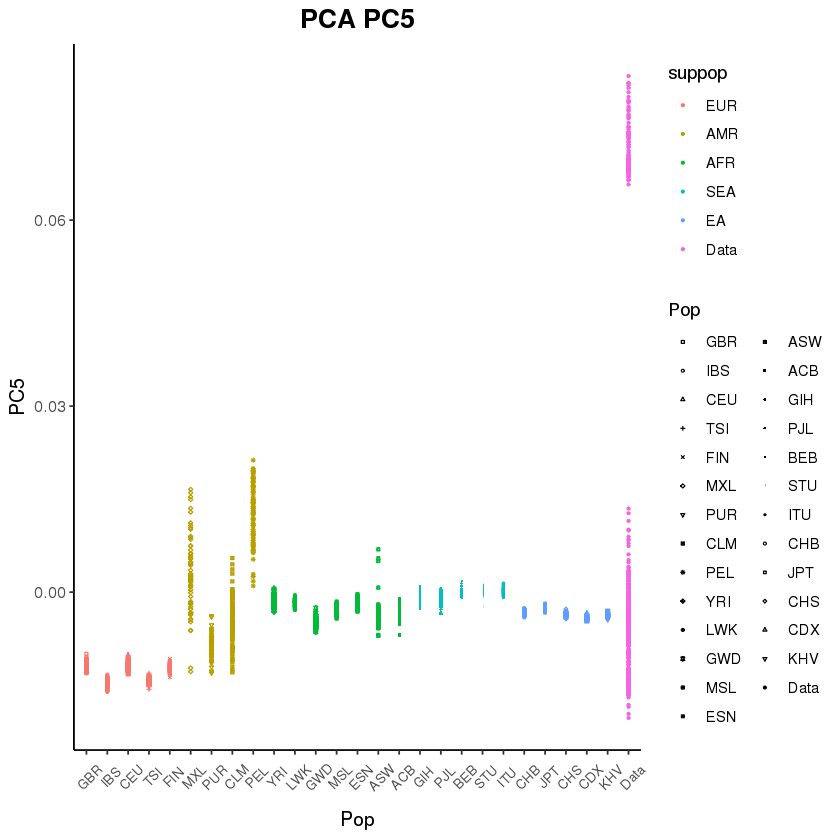

In [34]:
p3 <- ggplot(pcainput, aes(x = Pop, y = V7, shape = Pop, color = suppop)) +
  geom_point(size=.5) +
  scale_shape_manual(values = c(0:18,33,20:25,19)) +
  labs(y = "PC5", title = "PCA PC5") +
  theme_classic() +
  theme(axis.text = element_text(size=10),
        axis.text.x = element_text(angle = 45, size=8, margin = margin(0.4, unit = "cm")),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5))
p3
ggsave("~/project-gandalm/isoform_twas/genotype/figures/PC5.png", p3, width = 9, height = 6)

### 3: Ancestry inference

In [22]:
pca <- pcainput[,3:24]
rownames(pca) <- pcainput[,2]
pca_scale <- as.data.frame(scale(pca[,1:20], center = TRUE, scale = TRUE))

In [23]:
# 1kg as training set, data as testing set
n_ref <- 2504
n_data<- nrow(pca_scale) - n_ref

train_set <- pca_scale[1:n_ref,]
test_set <- pca_scale[(n_ref+1):nrow(pca_scale),]
train_label <- pca[1:n_ref,21] #suppop

In [24]:
n_data

[1] 654

In [26]:
length(train_label)

[1] 2504

In [27]:
# initialize K as the square root of number of sample in training set
# remember to set seed before knn. knn randomly breaks ties
set.seed(11)
K <- floor(sqrt(n_ref))
knn <- knn(train=train_set, test=test_set, cl=train_label, k=K)

In [28]:
table(knn)

knn
 EUR  AMR  AFR  SEA   EA Data 
 292  164  145   29   24    0 

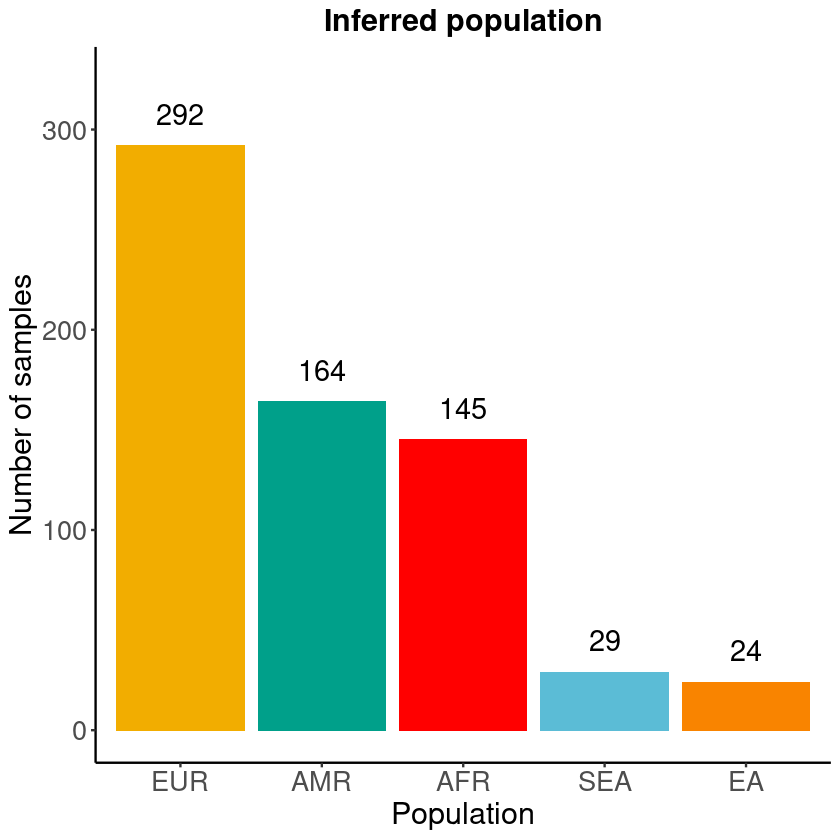

In [29]:
df <- data.frame("Population" = c("EUR","AMR","AFR","SEA","EA"),
                 "Count" = c(sum(knn=="EUR"),
                             sum(knn=="AMR"),
                             sum(knn=="AFR"),
                             sum(knn=="SEA"),
                             sum(knn=="EA")))
df$Population <- factor(df$Population, levels = c("EUR","AMR","AFR","SEA","EA"))

pal <- c("AFR" = "#FF0000", "AMR" = "#00A08A", "EUR" = "#F2AD00", 
         "EA" = "#F98400", "SEA" = "#5BBCD6", "Fetal sample" = "#FF61C3")


ggplot(df, aes(x = Population, y = Count)) +
  geom_bar(stat = "identity", aes(fill = Population)) +
  labs(x = "Population", y = "Number of samples", title = "Inferred population") +
  geom_text(aes(label = Count),vjust = -1, size = 6) +
  theme_classic() +
  theme(axis.text = element_text(size = 16),
        axis.title = element_text(size = 18),
        plot.title = element_text(size = 18, face = "bold", hjust = 0.5),
        legend.position = "none") +
  ylim(0,325) +
  scale_fill_manual(values = pal)

In [30]:
ggsave("~/project-gandalm/isoform_twas/genotype/figures/ancestry.pdf", width = 6, height = 6)

### 4: Write to subject lists

In [48]:
head(knn)

[1] EA  EUR EUR SEA EUR EUR
Levels: EUR AMR AFR SEA EA Data

In [50]:
length(knn)

[1] 654

In [32]:
eur <- amr <- afr <- sea <- ea <- c()
for(i in 1:n_data) {
  if (knn[i]=="EUR") {
    eur <- append(eur, rownames(pca)[n_ref+i])
  }
  if (knn[i]=="AFR") {
    afr <- append(afr, rownames(pca)[n_ref+i])
  }
  if (knn[i]=="AMR") {
    amr <- append(amr, rownames(pca)[n_ref+i])
  }
  if (knn[i]=="SEA") {
    sea <- append(sea, rownames(pca)[n_ref+i])
  }
  if (knn[i]=="EA") {
    ea <- append(ea, rownames(pca)[n_ref+i])
  }
}
# write.table(data.frame(eur), "../ancestry_list/list.eur.tsv", quote = FALSE, row.names = FALSE, col.names = FALSE, sep = '\t')
# write.table(data.frame(afr), "../ancestry_list/list.afr.tsv", quote = FALSE, row.names = FALSE, col.names = FALSE, sep = '\t')
# write.table(data.frame(amr), "../ancestry_list/list.amr.tsv", quote = FALSE, row.names = FALSE, col.names = FALSE, sep = '\t')
# write.table(data.frame(sea), "../ancestry_list/list.sea.tsv", quote = FALSE, row.names = FALSE, col.names = FALSE, sep = '\t')
# write.table(data.frame(ea), "../ancestry_list/list.ea.tsv", quote = FALSE, row.names = FALSE, col.names = FALSE, sep = '\t')

### 5: Plot ancestry distribution of each study

In [33]:
walker <- read.table("../geno_subj/geno_subj_walker.txt")
sum(eur %in% walker[,1])
sum(amr %in% walker[,1])
sum(afr %in% walker[,1])
sum(sea %in% walker[,1])
sum(ea %in% walker[,1])

[1] 33

[1] 107

[1] 55

[1] 0

[1] 16

In [34]:
walker_dat <- data.frame("Ancestry" = c("EUR", "AMR","AFR","SEA","EA"),
                        "count" = c(33,107,55,0,16))

In [35]:
obrien <- read.table("../geno_subj/geno_subj_obrien.txt")
sum(eur %in% obrien[,1])
sum(amr %in% obrien[,1])
sum(afr %in% obrien[,1])
sum(sea %in% obrien[,1])
sum(ea %in% obrien[,1])

[1] 86

[1] 8

[1] 18

[1] 7

[1] 1

In [36]:
obrien_dat <- data.frame("Ancestry" = c("EUR", "AMR","AFR","SEA","EA"),
                        "count" = c(86, 8, 18, 7, 1))

In [37]:
werling <- read.table("../geno_subj/geno_subj_werling.txt")
sum(eur %in% werling[,1])
sum(amr %in% werling[,1])
sum(afr %in% werling[,1])
sum(sea %in% werling[,1])
sum(ea %in% werling[,1])

[1] 54

[1] 36

[1] 22

[1] 1

[1] 3

In [38]:
werling_dat <- data.frame("Ancestry" = c("EUR", "AMR","AFR","SEA","EA"),
                        "count" = c(54,36,22,1,3))

In [39]:
libd <- read.table("../geno_subj/geno_subj_libd.txt")
sum(eur %in% libd[,1])
sum(amr %in% libd[,1])
sum(afr %in% libd[,1])
sum(sea %in% libd[,1])
sum(ea %in% libd[,1])

[1] 12

[1] 1

[1] 31

[1] 0

[1] 0

In [40]:
libd_dat <- data.frame("Ancestry" = c("EUR", "AMR","AFR","SEA","EA"),
                        "count" = c(12,1,31,0,0))

In [41]:
hdbr <- read.table("../geno_subj/geno_subj_hdbr.txt")
sum(eur %in% hdbr[,1])
sum(amr %in% hdbr[,1])
sum(afr %in% hdbr[,1])
sum(sea %in% hdbr[,1])
sum(ea %in% hdbr[,1])

[1] 107

[1] 12

[1] 19

[1] 21

[1] 4

In [42]:
hdbr_dat <- data.frame("Ancestry" = c("EUR", "AMR","AFR","SEA","EA"),
                        "count" = c(107,12,19,21,4))

In [43]:
all_df <- rbind(walker_dat, obrien_dat, werling_dat, hdbr_dat, libd_dat)

In [44]:
all_df$Data <- c(rep("Walker", 5), 
                 rep("Obrien", 5),
                 rep("Werling", 5),
                 rep("HDBR", 5),
                 rep("LIBD", 5))
all_df$Ancestry <- factor(all_df$Ancestry, levels = c("EUR","AMR","AFR","SEA","EA"))

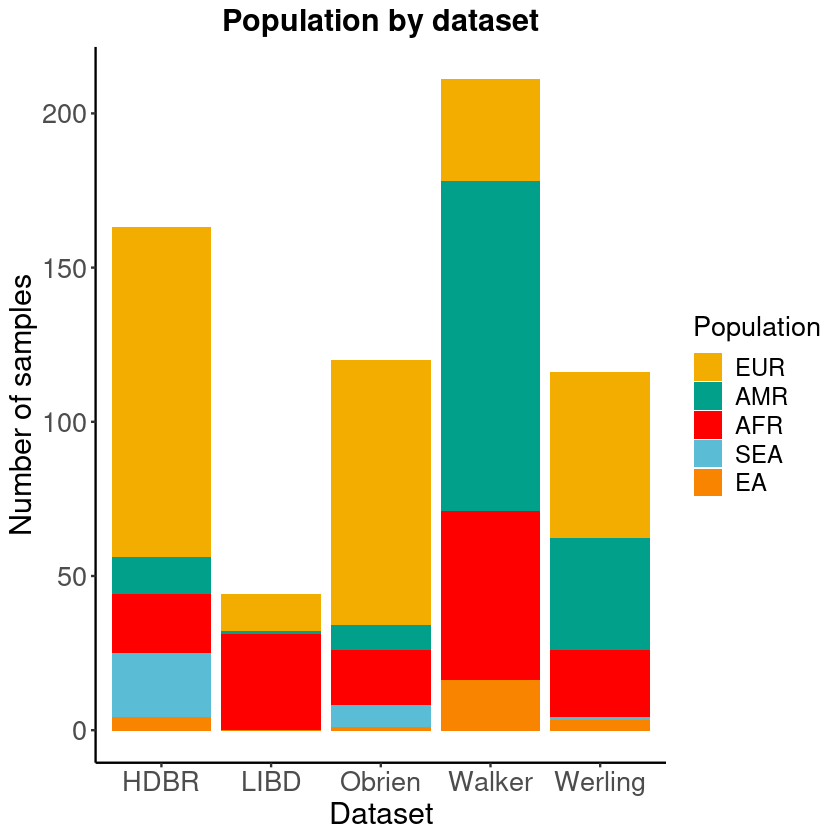

In [45]:
colnames(all_df)[1] <- "Population"

pal <- c("AFR" = "#FF0000", "AMR" = "#00A08A", "EUR" = "#F2AD00", 
         "EA" = "#F98400", "SEA" = "#5BBCD6", "Fetal sample" = "#FF61C3")

ggplot(all_df, aes(fill = Population, x = Data, y = count)) +
  geom_bar(position = "stack", stat = "identity") +
  labs(title = "Population by dataset", x = "Dataset", y = "Number of samples") +
  theme_classic() +
  theme(axis.text = element_text(size = 16), 
        axis.title = element_text(size = 18), 
        plot.title = element_text(size = 18, face = "bold", hjust = 0.5),
        legend.title = element_text(size = 16),
        legend.text = element_text(size = 14),
        legend.position = "right") +
  scale_fill_manual(values = pal)

In [46]:
ggsave("~/project-gandalm/isoform_twas/genotype/figures/ancestry_study.pdf", width = 8, height = 6)

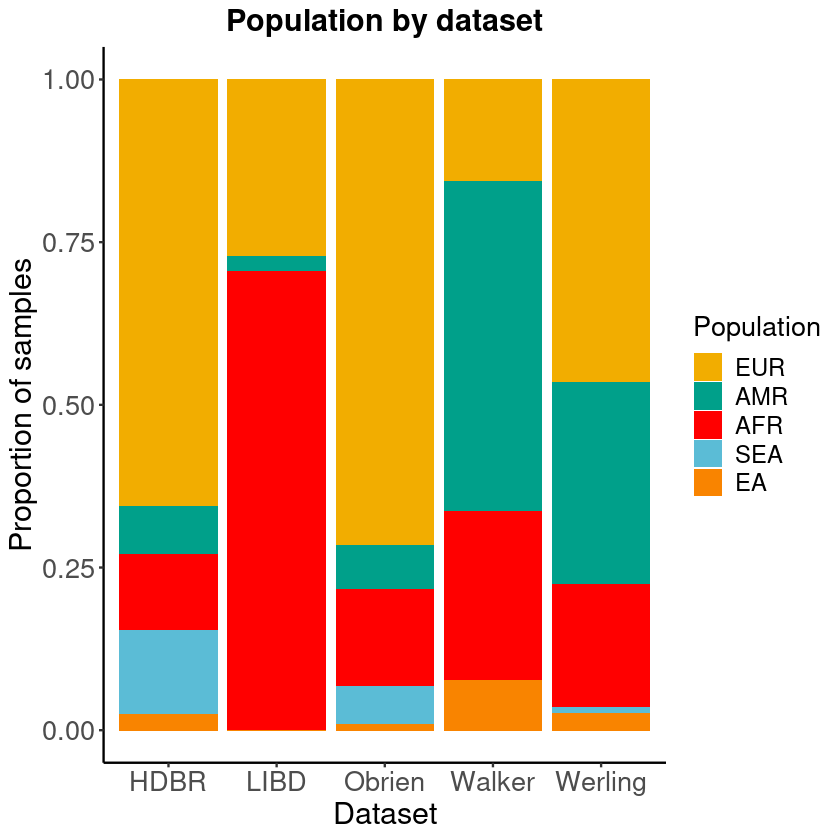

In [47]:
ggplot(all_df, aes(fill = Population, x = Data, y = count)) +
  geom_bar(position = "fill", stat = "identity") +
  labs(title = "Population by dataset", x = "Dataset", y = "Proportion of samples") +
  theme_classic() +
  theme(axis.text = element_text(size = 16), 
        axis.title = element_text(size = 18), 
        plot.title = element_text(size = 18, face = "bold", hjust = 0.5),
        legend.title = element_text(size = 16),
        legend.text = element_text(size = 14),
        legend.position = "right") +
  scale_fill_manual(values = pal)

In [48]:
ggsave("~/project-gandalm/isoform_twas/genotype/figures/ancestry_study_prop.pdf", width = 8, height = 6)

### 6: Plot PCA for EUR, AMR, AFR

In [2]:
setwd("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/")

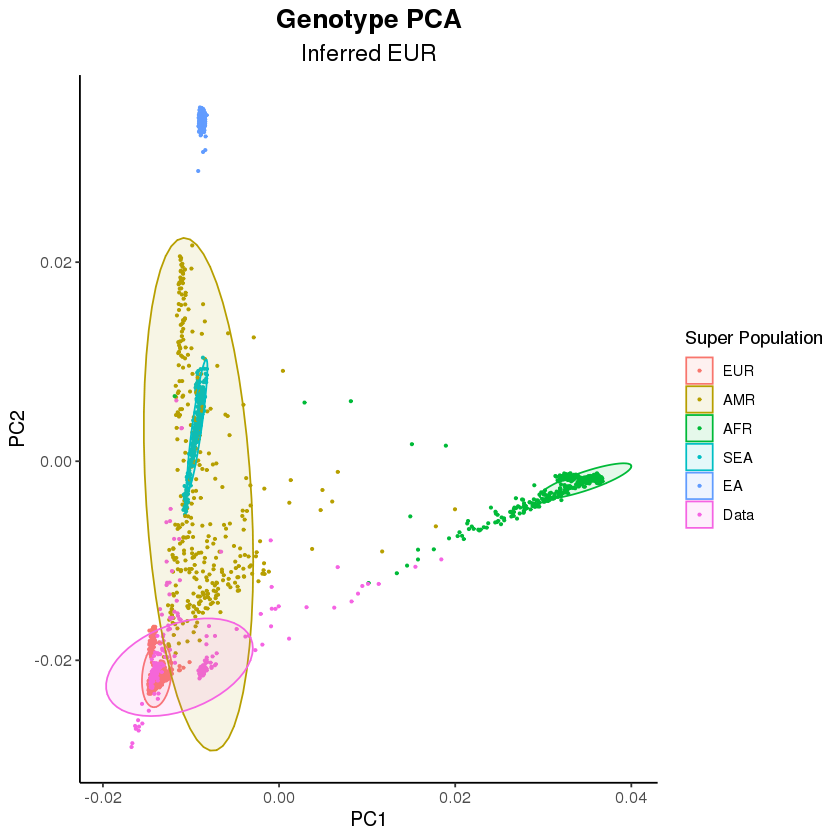

In [4]:
# EUR
pcainput <- fread("eur/pca/data.ref.eigenvec", data.table = F)
onekgpop <- fread("/u/project/gandalm/shared/refGenomes/1000genomes/chrs/kgp.pop", data.table = F)

pcainlist <- pcainput$V2 %in% onekgpop$IID
onekglist <- onekgpop$IID %in% pcainput$V2
pcainput$suppop <- "Data"
pcainput$Pop <- "Data"
onekgpop$suppop <- NA

for(i in 1:dim(onekgpop)[1]) {
  if (onekgpop[i,"POP"] %in% c("GBR", "IBS", "CEU", "TSI", "FIN")) {
    onekgpop[i,"suppop"] <- "EUR"
  }
  if (onekgpop[i,"POP"] %in% c("MXL", "PUR", "CLM", "PEL")) {
    onekgpop[i,"suppop"] <- "AMR"
  }
  if (onekgpop[i,"POP"] %in% c("YRI", "LWK", "GWD", "MSL", "ESN", "ASW", "ACB")) {
    onekgpop[i,"suppop"] <- "AFR"
  }
  if (onekgpop[i,"POP"] %in% c("GIH", "PJL", "BEB", "STU", "ITU")) {
    onekgpop[i,"suppop"] <- "SEA"
  }
  if (onekgpop[i,"POP"] %in% c("CHB", "JPT", "CHS", "CDX", "KHV")) {
    onekgpop[i,"suppop"] <- "EA"
  }
}

pcainput[pcainlist,]$Pop <- as.vector(onekgpop[onekglist,]$POP)
pcainput[pcainlist,]$suppop <- as.vector(onekgpop[onekglist,]$suppop)

poplevels <- c("GBR", "IBS", "CEU", "TSI", "FIN",               # EUR
              "MXL", "PUR", "CLM", "PEL",                      # Admix American
              "YRI", "LWK", "GWD", "MSL", "ESN", "ASW", "ACB", # African
              "GIH", "PJL", "BEB", "STU", "ITU",               # SEA
              "CHB", "JPT", "CHS", "CDX", "KHV",               # EA
              "Data")

poplevels2 <- c("EUR", "AMR", "AFR", "SEA", "EA", "Data")

pcainput$Pop <- factor(pcainput$Pop, levels = poplevels)
pcainput$suppop <- factor(pcainput$suppop, levels = poplevels2)

p <- ggplot(pcainput, aes(x=V3, y=V4, color=suppop)) +
  geom_point(size=.5) +
  stat_ellipse(geom="polygon", alpha=.1, aes(fill=suppop)) +
  labs(title = "Genotype PCA",
       subtitle = "Inferred EUR",
       x = "PC1", y = "PC2") +
  theme_classic() +
  theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5),
        plot.subtitle = element_text(size=14, hjust = 0.5)) +
  scale_fill_discrete("Super Population") +
  scale_colour_discrete("Super Population")

p

In [5]:
ggsave("~/project-gandalm/isoform_twas/genotype/figures/EUR_PC1vsPC2.png", p, width=8, height=6)

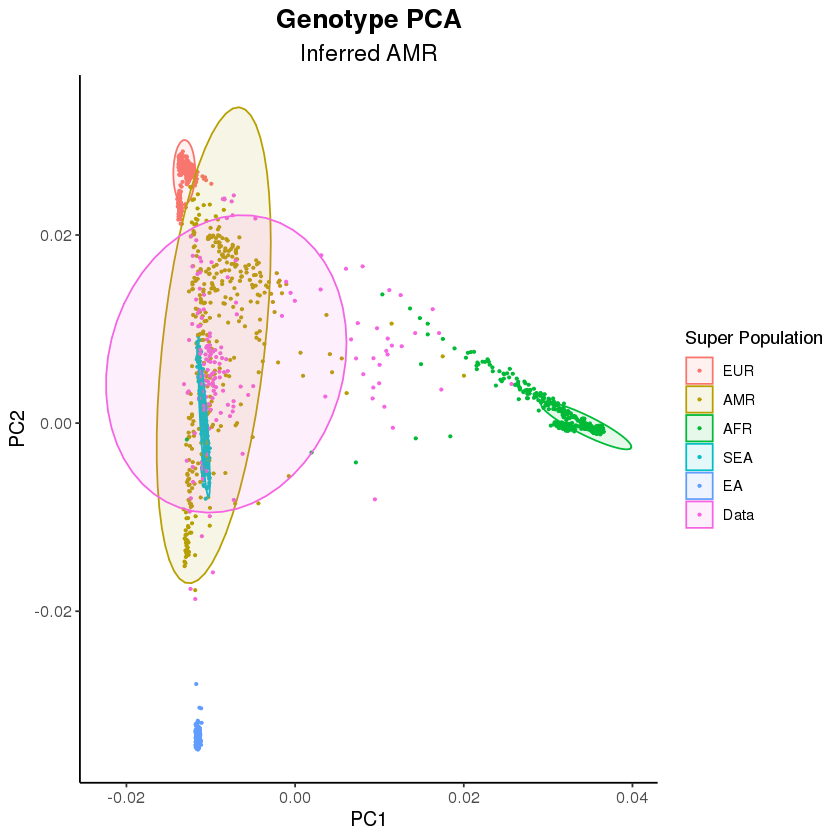

In [6]:
# AMR
pcainput <- fread("amr/pca/data.ref.eigenvec", data.table = F)
onekgpop <- fread("/u/project/gandalm/shared/refGenomes/1000genomes/chrs/kgp.pop", data.table = F)

pcainlist <- pcainput$V2 %in% onekgpop$IID
onekglist <- onekgpop$IID %in% pcainput$V2
pcainput$suppop <- "Data"
pcainput$Pop <- "Data"
onekgpop$suppop <- NA

for(i in 1:dim(onekgpop)[1]) {
  if (onekgpop[i,"POP"] %in% c("GBR", "IBS", "CEU", "TSI", "FIN")) {
    onekgpop[i,"suppop"] <- "EUR"
  }
  if (onekgpop[i,"POP"] %in% c("MXL", "PUR", "CLM", "PEL")) {
    onekgpop[i,"suppop"] <- "AMR"
  }
  if (onekgpop[i,"POP"] %in% c("YRI", "LWK", "GWD", "MSL", "ESN", "ASW", "ACB")) {
    onekgpop[i,"suppop"] <- "AFR"
  }
  if (onekgpop[i,"POP"] %in% c("GIH", "PJL", "BEB", "STU", "ITU")) {
    onekgpop[i,"suppop"] <- "SEA"
  }
  if (onekgpop[i,"POP"] %in% c("CHB", "JPT", "CHS", "CDX", "KHV")) {
    onekgpop[i,"suppop"] <- "EA"
  }
}

pcainput[pcainlist,]$Pop <- as.vector(onekgpop[onekglist,]$POP)
pcainput[pcainlist,]$suppop <- as.vector(onekgpop[onekglist,]$suppop)

poplevels <- c("GBR", "IBS", "CEU", "TSI", "FIN",               # EUR
              "MXL", "PUR", "CLM", "PEL",                      # Admix American
              "YRI", "LWK", "GWD", "MSL", "ESN", "ASW", "ACB", # African
              "GIH", "PJL", "BEB", "STU", "ITU",               # SEA
              "CHB", "JPT", "CHS", "CDX", "KHV",               # EA
              "Data")

poplevels2 <- c("EUR", "AMR", "AFR", "SEA", "EA", "Data")

pcainput$Pop <- factor(pcainput$Pop, levels = poplevels)
pcainput$suppop <- factor(pcainput$suppop, levels = poplevels2)

p <- ggplot(pcainput, aes(x=V3, y=V4, color=suppop)) +
  geom_point(size=.5) +
  stat_ellipse(geom="polygon", alpha=.1, aes(fill=suppop)) +
  labs(title = "Genotype PCA",
       subtitle = "Inferred AMR",
       x = "PC1", y = "PC2") +
  theme_classic() +
  theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5),
        plot.subtitle = element_text(size=14, hjust = 0.5)) +
  scale_fill_discrete("Super Population") +
  scale_colour_discrete("Super Population")

p

In [7]:
ggsave("~/project-gandalm/isoform_twas/genotype/figures/AMR_PC1vsPC2.png", p, width=8, height=6)

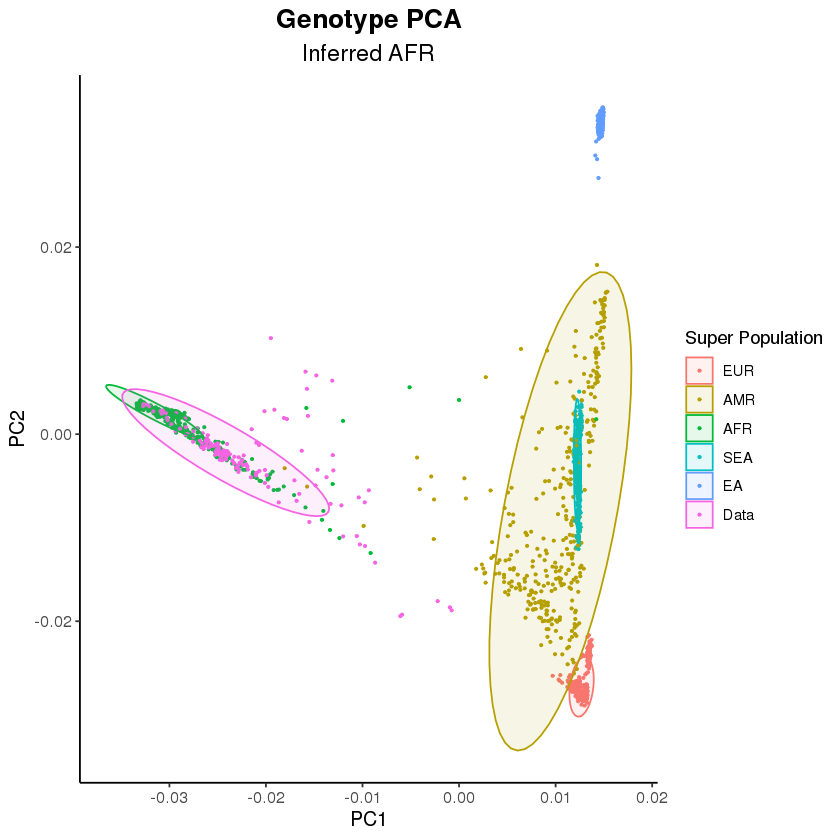

In [8]:
# AFR
pcainput <- fread("afr/pca/data.ref.eigenvec", data.table = F)
onekgpop <- fread("/u/project/gandalm/shared/refGenomes/1000genomes/chrs/kgp.pop", data.table = F)

pcainlist <- pcainput$V2 %in% onekgpop$IID
onekglist <- onekgpop$IID %in% pcainput$V2
pcainput$suppop <- "Data"
pcainput$Pop <- "Data"
onekgpop$suppop <- NA

for(i in 1:dim(onekgpop)[1]) {
  if (onekgpop[i,"POP"] %in% c("GBR", "IBS", "CEU", "TSI", "FIN")) {
    onekgpop[i,"suppop"] <- "EUR"
  }
  if (onekgpop[i,"POP"] %in% c("MXL", "PUR", "CLM", "PEL")) {
    onekgpop[i,"suppop"] <- "AMR"
  }
  if (onekgpop[i,"POP"] %in% c("YRI", "LWK", "GWD", "MSL", "ESN", "ASW", "ACB")) {
    onekgpop[i,"suppop"] <- "AFR"
  }
  if (onekgpop[i,"POP"] %in% c("GIH", "PJL", "BEB", "STU", "ITU")) {
    onekgpop[i,"suppop"] <- "SEA"
  }
  if (onekgpop[i,"POP"] %in% c("CHB", "JPT", "CHS", "CDX", "KHV")) {
    onekgpop[i,"suppop"] <- "EA"
  }
}

pcainput[pcainlist,]$Pop <- as.vector(onekgpop[onekglist,]$POP)
pcainput[pcainlist,]$suppop <- as.vector(onekgpop[onekglist,]$suppop)

poplevels <- c("GBR", "IBS", "CEU", "TSI", "FIN",               # EUR
              "MXL", "PUR", "CLM", "PEL",                      # Admix American
              "YRI", "LWK", "GWD", "MSL", "ESN", "ASW", "ACB", # African
              "GIH", "PJL", "BEB", "STU", "ITU",               # SEA
              "CHB", "JPT", "CHS", "CDX", "KHV",               # EA
              "Data")

poplevels2 <- c("EUR", "AMR", "AFR", "SEA", "EA", "Data")

pcainput$Pop <- factor(pcainput$Pop, levels = poplevels)
pcainput$suppop <- factor(pcainput$suppop, levels = poplevels2)

p <- ggplot(pcainput, aes(x=V3, y=V4, color=suppop)) +
  geom_point(size=.5) +
  stat_ellipse(geom="polygon", alpha=.1, aes(fill=suppop)) +
  labs(title = "Genotype PCA",
       subtitle = "Inferred AFR",
       x = "PC1", y = "PC2") +
  theme_classic() +
  theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5),
        plot.subtitle = element_text(size=14, hjust = 0.5)) +
  scale_fill_discrete("Super Population") +
  scale_colour_discrete("Super Population")

p

In [9]:
ggsave("~/project-gandalm/isoform_twas/genotype/figures/AFR_PC1vsPC2.png", p, width=8, height=6)

### 7: Write ancestry list for all subjects

In [4]:
eur <- read.table("../ancestry_list/list.eur.tsv", header = F, stringsAsFactors = F)
amr <- read.table("../ancestry_list/list.amr.tsv", header = F, stringsAsFactors = F)
afr <- read.table("../ancestry_list/list.afr.tsv", header = F, stringsAsFactors = F)
sea <- read.table("../ancestry_list/list.sea.tsv", header = F, stringsAsFactors = F)
ea <- read.table("../ancestry_list/list.ea.tsv", header = F, stringsAsFactors = F)

In [9]:
df <- rbind(eur, amr, afr, sea, ea)

In [10]:
dim(df)

[1] 654   1

In [12]:
df$V2 <- c(rep("eur", nrow(eur)),
          rep("amr", nrow(amr)),
          rep("afr", nrow(afr)),
          rep("sea", nrow(sea)),
          rep("ea", nrow(ea)))

In [13]:
head(df)

,V1,V2
,<chr>,<chr>
1,898,eur
2,1038,eur
3,1046,eur
4,1092,eur
5,1102,eur
6,1107,eur


In [14]:
colnames(df) <- c("subject", "ancestry")

In [15]:
write.table(df, "../ancestry_list/ancestry.tsv",
           col.names = T, row.names = F, sep = "\t", quote = F)

### Supplemental
GENESIS ancestry PCA shows divergence between HDBR and all the other datasets. Check here. 

In [37]:
pcainput <- fread("data.ref.eigenvec", data.table = F)
pcs <- pcainput[2505:nrow(pcainput),]

In [38]:
walker <- read.table("../geno_subj/geno_subj_walker.txt", header = F, stringsAsFactors = F)
obrien <- read.table("../geno_subj/geno_subj_obrien.txt", header = F, stringsAsFactors = F)
werling <- read.table("../geno_subj/geno_subj_werling.txt", header = F, stringsAsFactors = F)
libd <- read.table("../geno_subj/geno_subj_libd.txt", header = F, stringsAsFactors = F)
hdbr <- read.table("../geno_subj/geno_subj_hdbr.txt", header = F, stringsAsFactors = F)

In [39]:
pcs$Study <- NA
for(i in 1:nrow(pcs)) {
    if(pcs[i, 1] %in% walker[,1]) {pcs[i, "Study"] <- "Walker"}
    if(pcs[i, 1] %in% obrien[,1]) {pcs[i, "Study"] <- "Obrien"}
    if(pcs[i, 1] %in% werling[,1]) {pcs[i, "Study"] <- "Werling"}
    if(pcs[i, 1] %in% libd[,1]) {pcs[i, "Study"] <- "LIBD"}
    if(pcs[i, 1] %in% hdbr[,1]) {pcs[i, "Study"] <- "HDBR"}
}

In [41]:
table(pcs$Study)


   HDBR    LIBD  Obrien  Walker Werling 
    163      44     120     211     116 

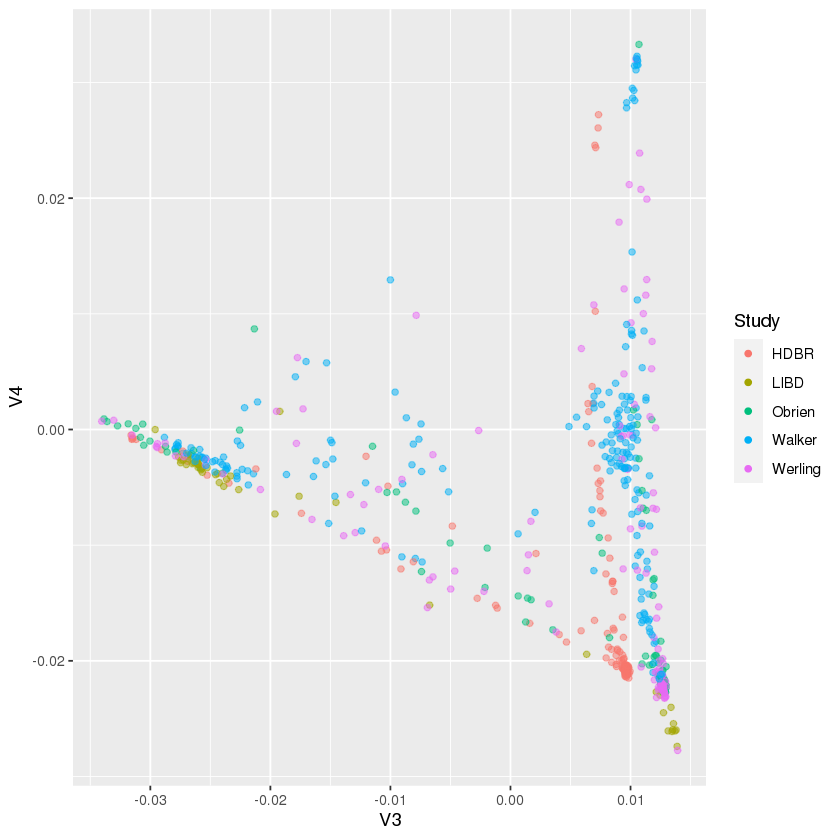

In [42]:
p <- ggplot(pcs, aes(V3, V4, color=Study)) + geom_point(alpha=0.5) +
    guides(colour=guide_legend(override.aes=list(alpha=1)))
p

### Check PCs

In [10]:
pca <- fread("data.ref.eigenvec", data.table = F)
head(pca)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,⋯,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,HG00096,0.0128305,-0.0225484,-0.00550327,0.0133238,-0.01208590,-3.67376e-04,0.00543167,-0.00972743,⋯,0.002524860,-0.00419044,-0.002421520,1.96515e-03,0.00878319,-0.001155100,-0.002759000,4.40420e-04,0.000598392,0.00859479
2,0,HG00097,0.0129049,-0.0230081,-0.00565654,0.0125673,-0.01126800,-7.29960e-04,0.00548691,-0.01091880,⋯,-0.001751470,-0.00377310,-0.001106570,6.29591e-05,0.00699433,-0.000710293,-0.002333510,2.21643e-03,-0.000370897,0.00406125
3,0,HG00099,0.0129766,-0.0228803,-0.00518720,0.0118207,-0.00994349,1.23529e-04,0.00786745,-0.01458900,⋯,0.002250670,-0.00380988,-0.000981348,2.51044e-03,0.00296698,0.001305700,-0.001196110,-1.93197e-04,0.004725180,0.00869112
4,0,HG00100,0.0127320,-0.0231663,-0.00462434,0.0122995,-0.01213090,7.89135e-04,0.00432195,-0.00988932,⋯,0.000250502,-0.00704631,-0.003585090,1.97756e-03,0.01645620,-0.003030650,0.000634721,8.48377e-06,0.005076280,0.00726876
5,0,HG00101,0.0128811,-0.0226109,-0.00581955,0.0126541,-0.01150170,-2.67085e-04,0.00513942,-0.01197810,⋯,0.001801970,-0.00123539,0.000885783,2.22905e-03,0.00424707,-0.002058190,-0.002241630,2.13131e-03,-0.000574230,0.00882203
6,0,HG00102,0.0130800,-0.0227202,-0.00528723,0.0128514,-0.01163850,1.79776e-07,0.00848940,-0.01641380,⋯,-0.000435352,-0.00669128,-0.003238650,1.12421e-03,0.01266530,-0.002250640,-0.001702330,-2.16601e-03,0.003055300,0.01015800


In [11]:
pca <- pca[,-1]
rownames(pca) <- pca[,1]
pca <- pca[,-1]
head(pca)

,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
HG00096,0.0128305,-0.0225484,-0.00550327,0.0133238,-0.01208590,-3.67376e-04,0.00543167,-0.00972743,-3.93947e-04,-0.000659258,0.002524860,-0.00419044,-0.002421520,1.96515e-03,0.00878319,-0.001155100,-0.002759000,4.40420e-04,0.000598392,0.00859479
HG00097,0.0129049,-0.0230081,-0.00565654,0.0125673,-0.01126800,-7.29960e-04,0.00548691,-0.01091880,1.71128e-03,0.004943420,-0.001751470,-0.00377310,-0.001106570,6.29591e-05,0.00699433,-0.000710293,-0.002333510,2.21643e-03,-0.000370897,0.00406125
HG00099,0.0129766,-0.0228803,-0.00518720,0.0118207,-0.00994349,1.23529e-04,0.00786745,-0.01458900,-1.44397e-03,0.000282191,0.002250670,-0.00380988,-0.000981348,2.51044e-03,0.00296698,0.001305700,-0.001196110,-1.93197e-04,0.004725180,0.00869112
HG00100,0.0127320,-0.0231663,-0.00462434,0.0122995,-0.01213090,7.89135e-04,0.00432195,-0.00988932,-8.98822e-05,0.000475853,0.000250502,-0.00704631,-0.003585090,1.97756e-03,0.01645620,-0.003030650,0.000634721,8.48377e-06,0.005076280,0.00726876
HG00101,0.0128811,-0.0226109,-0.00581955,0.0126541,-0.01150170,-2.67085e-04,0.00513942,-0.01197810,4.45135e-04,0.000802321,0.001801970,-0.00123539,0.000885783,2.22905e-03,0.00424707,-0.002058190,-0.002241630,2.13131e-03,-0.000574230,0.00882203
HG00102,0.0130800,-0.0227202,-0.00528723,0.0128514,-0.01163850,1.79776e-07,0.00848940,-0.01641380,-7.23878e-04,-0.005335250,-0.000435352,-0.00669128,-0.003238650,1.12421e-03,0.01266530,-0.002250640,-0.001702330,-2.16601e-03,0.003055300,0.01015800


In [12]:
data.pca <- pca[2505:nrow(pca),]
dim(data.pca)
head(data.pca)

[1] 654  20

,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
849,0.00702467,0.02457830,-0.00538244,0.02529370,0.0693614,-0.00242904,-0.002745760,0.00719920,0.003373480,0.00200802,-0.00553277,0.00497178,-0.01232050,-0.01000390,-0.00317209,0.000364911,7.14981e-05,-0.001197680,-0.000925518,0.002423900
898,0.00983834,-0.02057090,-0.00537699,0.02166890,0.0681412,-0.00384078,-0.000454382,-0.00208607,-0.002342760,-0.00245872,0.00415838,-0.00403165,0.00965402,0.00650714,0.00631236,-0.002553740,3.00899e-03,-0.000838735,-0.002658280,0.012701100
1038,0.00972369,-0.02112310,-0.00542681,0.02313770,0.0687397,-0.00422769,-0.001473210,-0.00143631,-0.002084000,0.00326985,0.00221363,-0.00608101,0.01138900,0.00795394,0.00554499,0.000800906,-1.18729e-03,-0.000168556,0.004045990,0.016168600
1039,0.00685610,0.00222942,0.02247420,0.00359596,0.0813049,-0.00277704,-0.001613240,0.00394666,0.001751410,0.00176000,-0.00156295,0.00228406,-0.00529612,-0.00455582,-0.00363268,0.000457433,3.41729e-04,0.001944100,-0.001200410,0.000668306
1046,0.00970374,-0.02123060,-0.00507569,0.02292680,0.0678574,-0.00301320,-0.001476110,-0.00400135,-0.000361235,-0.00134346,0.00257815,-0.00962720,0.01122580,0.00714457,0.00723173,0.000293031,5.60713e-04,0.000382903,0.002994970,0.012237600
1092,0.00969336,-0.02103760,-0.00447605,0.02300700,0.0676113,-0.00340325,-0.000492295,-0.00544784,-0.001190980,-0.00471703,0.00291503,-0.00603513,0.01109450,0.00854499,0.01021360,-0.002109810,-2.18231e-03,-0.001348800,0.002865460,0.011383600


[1] 654  10

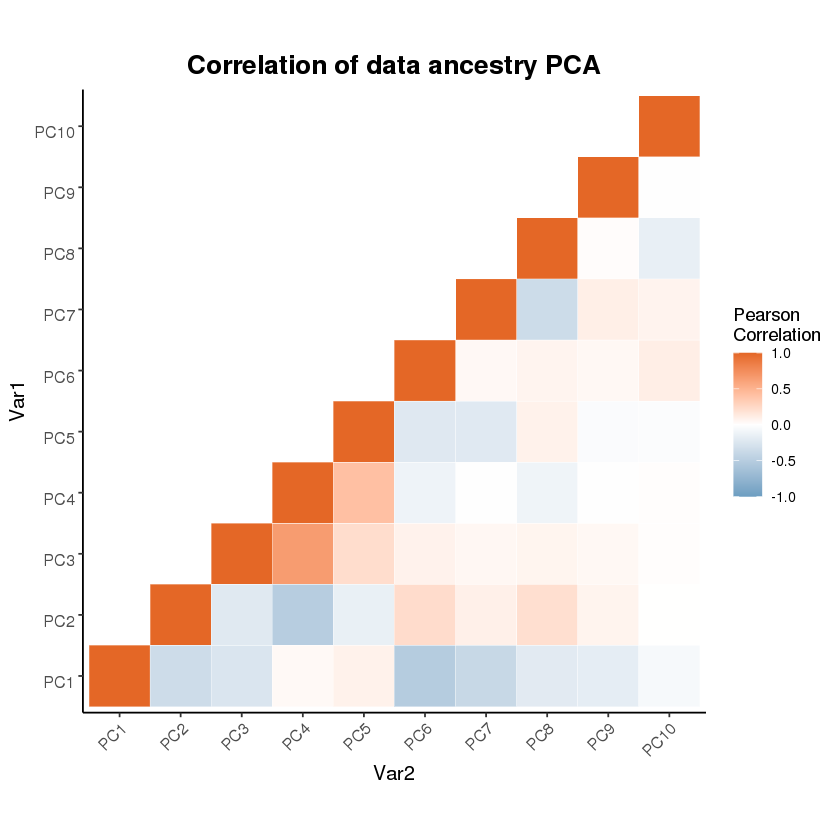

In [18]:
library(reshape2)

data.pca <- data.pca[,1:10]
names(data.pca) <- paste0("PC", seq(1:10))
dim(data.pca)

res <- cor(data.pca, method = "pearson")

res[lower.tri(res)] <- NA
upper.melted <- melt(res, na.rm = TRUE)

ggplot(data = upper.melted, aes(Var2, Var1, fill = value)) +
 geom_tile(color = "white") +
 scale_fill_gradient2(low = "#6D9EC1", high = "#E46726", mid = "white", 
   midpoint = 0, limit = c(-1,1), space = "Lab", 
   name="Pearson\nCorrelation") +
 theme_classic() + 
 theme(axis.text.x = element_text(angle = 45, vjust = 1, 
    size = 10, hjust = 1),
       axis.text.y = element_text(vjust = 1, 
    size = 10, hjust = 1),
       axis.title = element_text(size=12),
       plot.title = element_text(size=16, face="bold", hjust = 0.5)) +
 ggtitle("Correlation of data ancestry PCA") +
 coord_fixed()

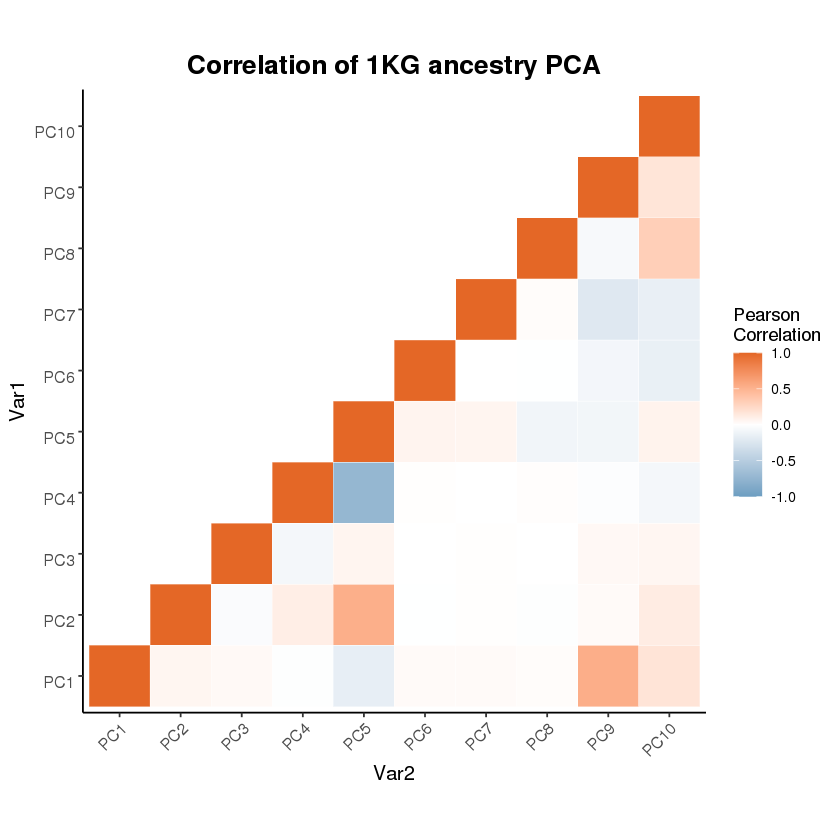

In [19]:
ref.pca <- pca[1:2504,1:10]
names(ref.pca) <- paste0("PC", seq(1:10))
ref.res <- cor(ref.pca, method = "pearson")

ref.res[lower.tri(ref.res)] <- NA
ref.upper.melted <- melt(ref.res, na.rm = TRUE)

ggplot(data = ref.upper.melted, aes(Var2, Var1, fill = value)) +
 geom_tile(color = "white") +
 scale_fill_gradient2(low = "#6D9EC1", high = "#E46726", mid = "white", 
   midpoint = 0, limit = c(-1,1), space = "Lab", 
   name="Pearson\nCorrelation") +
 theme_classic() + 
 theme(axis.text.x = element_text(angle = 45, vjust = 1, 
    size = 10, hjust = 1),
       axis.text.y = element_text(vjust = 1, 
    size = 10, hjust = 1),
       axis.title = element_text(size=12),
       plot.title = element_text(size=16, face="bold", hjust = 0.5)) +
 ggtitle("Correlation of 1KG ancestry PCA") +
 coord_fixed()